# Testing 2 Methods of Calibrating Deact Model Probabilities

1. Sigmoid (Logistic) Regression
2. Isotonic Regression

In [1]:
import deact
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType, StringType

In [2]:
warehouse_location = 'hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/grp_gdoop_clv_hiveDB.db'
python_location = './ANACONDA/anaconda2_env/bin/python'
archives_location = 'hdfs:////user/grp_gdoop_admin/anaconda/anaconda2_env.zip#ANACONDA'

spark = SparkSession\
	.builder\
	.master('yarn')\
	.appName('deact-model')\
	.config('spark.submit.deployMode','client')\
	.config('spark.executor.instances', 50)\
	.config('spark.yarn.appMasterEnv.PYSPARK_PYTHON',python_location)\
	.config('spark.yarn.dist.archives',archives_location)\
	.config('spark.sql.warehouse.dir',warehouse_location)\
	.config('spark.yarn.queue','public')\
	.enableHiveSupport()\
	.getOrCreate()
    
spark

# Dataset

+ Using validation data from 11/10/2019 `gradient_boosted_trees` model
+ Adding `prob_feature` column: `VectorAssembler` on just `prob_deact` column

In [3]:
df_raw = spark \
    .read \
    .orc('hdfs://cerebro-namenode-vip.snc1/user/grp_gdoop_clv/deact-model/ce_keep_deact_predictions1/record_date=2018-11-10/model=gradient_boosted_trees')

df_raw.show(10)

+--------------------+---------+-----------+-------------------+----------+
|         consumer_id|recency_x|deactivated|         prob_deact|prediction|
+--------------------+---------+-----------+-------------------+----------+
|000302c6-7e40-11e...|       65|          1| 0.8741686185267605|       1.0|
|00079780-4647-11e...|      202|          1| 0.8954133156851393|       1.0|
|00098426-1065-11e...|      252|          0| 0.8076543619470364|       1.0|
|000b9fc2-42e9-11e...|       50|          1| 0.5570938521635066|       1.0|
|000d5098-2fcc-11e...|      189|          1| 0.8532173865547072|       1.0|
|000fb38c-f103-11e...|      155|          0| 0.4656176191112176|       0.0|
|0012cece-27d1-11e...|      350|          1| 0.8749661774798758|       1.0|
|0013b3de-2457-11e...|      152|          1| 0.8821443330348874|       1.0|
|00155d10-cc8b-11e...|      356|          1| 0.9507838074689884|       1.0|
|0015c032-28aa-11e...|        2|          0|0.05018878010732897|       0.0|
+-----------

In [4]:
from pyspark.ml.feature import VectorAssembler
pred_df = VectorAssembler(inputCols=['prob_deact'], outputCol='prob_feature', handleInvalid='keep') \
    .transform(df_raw)

pred_df.show(10)

+--------------------+---------+-----------+-------------------+----------+--------------------+
|         consumer_id|recency_x|deactivated|         prob_deact|prediction|        prob_feature|
+--------------------+---------+-----------+-------------------+----------+--------------------+
|000302c6-7e40-11e...|       65|          1| 0.8741686185267605|       1.0|[0.8741686185267605]|
|00079780-4647-11e...|      202|          1| 0.8954133156851393|       1.0|[0.8954133156851393]|
|00098426-1065-11e...|      252|          0| 0.8076543619470364|       1.0|[0.8076543619470364]|
|000b9fc2-42e9-11e...|       50|          1| 0.5570938521635066|       1.0|[0.5570938521635066]|
|000d5098-2fcc-11e...|      189|          1| 0.8532173865547072|       1.0|[0.8532173865547072]|
|000fb38c-f103-11e...|      155|          0| 0.4656176191112176|       0.0|[0.4656176191112176]|
|0012cece-27d1-11e...|      350|          1| 0.8749661774798758|       1.0|[0.8749661774798758]|
|0013b3de-2457-11e...|      15

In [5]:
graph_df = pred_df \
    .withColumn('prob_bucket', F.round(F.col('prob_deact'), 2))\
    .groupBy('prob_bucket')\
    .agg(F.avg('deactivated').alias('pct_deactivated'))\
    .sort('prob_bucket')\
    .toPandas()
    
graph_df.head(10)

,prob_bucket,pct_deactivated
0,0.05,0.007325
1,0.06,0.021643
2,0.07,0.029998
3,0.08,0.044699
4,0.09,0.060316
5,0.10,0.074155
6,0.11,0.090068
7,0.12,0.104339
8,0.13,0.123558
9,0.14,0.136259


# Platt Scaling

### 1. Logistic Regression

label = LR(probabilities)

In [6]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol='prob_feature',
    labelCol='deactivated',
    predictionCol='prediction_cal',
    #maxIter=100,
    #regParam=0.0,
    #elasticNetParam=0.0,
    #tol=1e-06,
    #fitIntercept=True,
    #threshold=0.5,
    #thresholds=None,
    probabilityCol='probability_cal',
    rawPredictionCol='rawPrediction_cal',
    #standardization=True,
    #weightCol=None,
    #aggregationDepth=2,
    #family='auto',
    #lowerBoundsOnCoefficients=None,
    #upperBoundsOnCoefficients=None,
    #lowerBoundsOnIntercepts=None,
    #upperBoundsOnIntercepts=None,
)
lr

LogisticRegression_fb9a7e83ea82

In [7]:
lrModel = lr.fit(pred_df)
lrModel

LogisticRegressionModel: uid = LogisticRegression_fb9a7e83ea82, numClasses = 2, numFeatures = 1

In [8]:
lrModel.coefficients

DenseVector([5.1968])

In [9]:
lrModel.intercept

-2.586985010944725

In [10]:
lrModel.summary.objectiveHistory

[0.6555757657574729,
 0.6329109341819438,
 0.6159955785072719,
 0.5245137370793128,
 0.5030641477584709,
 0.4965930521761049,
 0.49627808231960346,
 0.4962721637932687,
 0.49627209575919273,
 0.49627209113697296,
 0.49627209111534465]

In [12]:
prob_deact = F.udf(lambda x: x.toArray().tolist()[1], DoubleType())
pred_df_sig = lrModel.transform(pred_df)\
    .withColumn('prob_deact_cal', prob_deact(F.col('probability_cal')))\
    .drop('rawPrediction_cal','probability_cal','prob_feature')

pred_df_sig.show()

+--------------------+---------+-----------+-------------------+----------+--------------+-------------------+
|         consumer_id|recency_x|deactivated|         prob_deact|prediction|prediction_cal|     prob_deact_cal|
+--------------------+---------+-----------+-------------------+----------+--------------+-------------------+
|000302c6-7e40-11e...|       65|          1| 0.8741686185267605|       1.0|           1.0| 0.8760883974436451|
|00079780-4647-11e...|      202|          1| 0.8954133156851393|       1.0|           1.0| 0.8875846206808716|
|00098426-1065-11e...|      252|          0| 0.8076543619470364|       1.0|           1.0| 0.8334442835374394|
|000b9fc2-42e9-11e...|       50|          1| 0.5570938521635066|       1.0|           1.0|  0.576427024579805|
|000d5098-2fcc-11e...|      189|          1| 0.8532173865547072|       1.0|           1.0| 0.8637767319454714|
|000fb38c-f103-11e...|      155|          0| 0.4656176191112176|       0.0|           0.0| 0.4582819186692861|
|

In [13]:
graph_df_sig = pred_df_sig \
    .withColumn('prob_bucket', F.round(F.col('prob_deact_cal'), 2))\
    .groupBy('prob_bucket')\
    .agg(F.avg('deactivated').alias('pct_deactivated'))\
    .sort('prob_bucket')\
    .toPandas()
    
graph_df_sig.head(10)

,prob_bucket,pct_deactivated
0,0.09,0.015404
1,0.10,0.037777
2,0.11,0.067686
3,0.12,0.096183
4,0.13,0.125328
5,0.14,0.145041
6,0.15,0.162824
7,0.16,0.178420
8,0.17,0.192913
9,0.18,0.206200


### Isotonic Regression

label = IR(probabilities)

In [14]:
from pyspark.ml.regression import IsotonicRegression

ir = IsotonicRegression(
    #isotonic=True,
    labelCol='deactivated',
    predictionCol='prob_deact_cal',
    #featureIndex=0,
    featuresCol='prob_feature',
)
ir

IsotonicRegression_a7c02dbb4c7c

In [15]:
irModel = ir.fit(pred_df)
irModel

IsotonicRegression_a7c02dbb4c7c

In [16]:
pred_df_iso = irModel\
    .transform(pred_df)\
    .drop('prob_feature')

pred_df_iso.show()

+--------------------+---------+-----------+-------------------+----------+--------------------+
|         consumer_id|recency_x|deactivated|         prob_deact|prediction|      prob_deact_cal|
+--------------------+---------+-----------+-------------------+----------+--------------------+
|000302c6-7e40-11e...|       65|          1| 0.8741686185267605|       1.0|  0.8872210657024945|
|00079780-4647-11e...|      202|          1| 0.8954133156851393|       1.0|   0.916022487702038|
|00098426-1065-11e...|      252|          0| 0.8076543619470364|       1.0|  0.7942038868053188|
|000b9fc2-42e9-11e...|       50|          1| 0.5570938521635066|       1.0|  0.5683675723437155|
|000d5098-2fcc-11e...|      189|          1| 0.8532173865547072|       1.0|  0.8556135239514873|
|000fb38c-f103-11e...|      155|          0| 0.4656176191112176|       0.0|  0.4728183118741059|
|0012cece-27d1-11e...|      350|          1| 0.8749661774798758|       1.0|  0.8872210657024945|
|0013b3de-2457-11e...|      15

In [17]:
graph_df_iso = pred_df_iso \
    .withColumn('prob_bucket', F.round(F.col('prob_deact_cal'), 2))\
    .groupBy('prob_bucket')\
    .agg(F.avg('deactivated').alias('pct_deactivated'))\
    .sort('prob_bucket')\
    .toPandas()

graph_df_iso.head(10)

,prob_bucket,pct_deactivated
0,0.00,0.003199
1,0.01,0.009140
2,0.02,0.019535
3,0.03,0.027077
4,0.04,0.039588
5,0.05,0.048372
6,0.06,0.056613
7,0.07,0.072201
8,0.08,0.083553
9,0.09,0.087647


### Calibration Graph

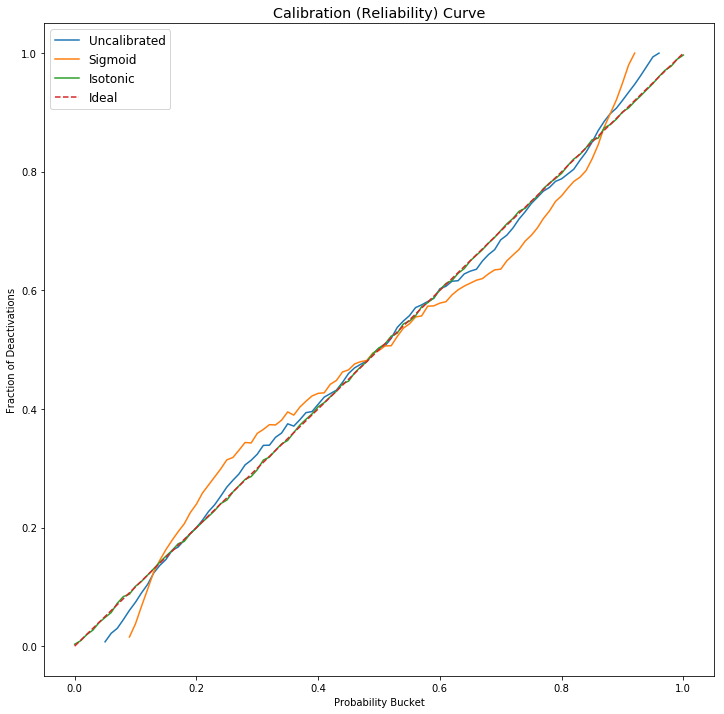

In [19]:
fig = plt.figure(figsize=(12, 12))
plt.plot(graph_df.prob_bucket, graph_df.pct_deactivated, marker='', label='Uncalibrated')
plt.plot(graph_df_sig.prob_bucket, graph_df_sig.pct_deactivated, marker='', label='Sigmoid')
plt.plot(graph_df_iso.prob_bucket, graph_df_iso.pct_deactivated, marker='', label='Isotonic')
plt.plot([0, 1], [0, 1], marker='', linestyle='--', label='Ideal')
plt.title('Calibration (Reliability) Curve', fontsize='x-large')
plt.xlabel('Probability Bucket')
plt.ylabel('Fraction of Deactivations')
plt.legend(loc='best', fontsize='large')

fig

Isotonic performs very well. Sigmoid is actually worse than the original model - not flexible enough.

# Results of Isotonic Regression

### Summary

Isotonic calibration:
+ Reduces log-loss by 0.5%
+ Barely affects accuracy (since accuracy is calculated using a 0.5 cutoff, people have to move from one side of the cutoff to the other to change accuracy)
+ Raised total predicted deacts by 0.6%
+ Barely affects ROC

In [20]:
# Log Loss
pred_df_iso \
    .withColumn('log_loss', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact')))) \
    .withColumn('log_loss_cal', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact_cal')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact_cal')))) \
    .agg(F.avg('log_loss').alias('avg_log_loss'),
         F.avg('log_loss_cal').alias('avg_log_loss_calibrated'),
        ) \
    .show()

+-----------------+-----------------------+
|     avg_log_loss|avg_log_loss_calibrated|
+-----------------+-----------------------+
|0.490886109769096|     0.4883549849249784|
+-----------------+-----------------------+



In [21]:
# Accuracy
pred_df_iso \
    .withColumn('prediction_cal', F.round(F.col('prob_deact_cal'), 0)) \
    .agg(F.avg((F.col('deactivated') == F.col('prediction')).cast(IntegerType())).alias('accuracy'),
         F.avg((F.col('deactivated') == F.col('prediction_cal')).cast(IntegerType())).alias('accuracy_calibrated'),
        ) \
    .show()

+------------------+-------------------+
|          accuracy|accuracy_calibrated|
+------------------+-------------------+
|0.7596854834489338| 0.7597146687170157|
+------------------+-------------------+



In [22]:
# Predicted / Actual Deacts
pred_df_iso \
    .agg(F.sum(F.col('deactivated')).alias('deacts_actual'),
         F.sum(F.col('prob_deact')).cast(IntegerType()).alias('deacts_pred'),
         F.sum(F.col('prob_deact_cal')).cast(IntegerType()).alias('deacts_pred_calibrated')
        ) \
    .withColumn('ratio', F.col('deacts_pred') / F.col('deacts_actual')) \
    .withColumn('ratio_calibrated', F.col('deacts_pred_calibrated') / F.col('deacts_actual')) \
    .show()

+-------------+-----------+----------------------+------------------+------------------+
|deacts_actual|deacts_pred|deacts_pred_calibrated|             ratio|  ratio_calibrated|
+-------------+-----------+----------------------+------------------+------------------+
|      1896471|    1884212|               1896443|0.9935358885002723|0.9999852357352156|
+-------------+-----------+----------------------+------------------+------------------+



### ROC

In [47]:
d = {'cutoff': [], 'tpr': [], 'fpr': [], 'tpr_c': [], 'fpr_c': []}

pos = pred_df_iso.filter(pred_df_iso.deactivated == 1).cache()
neg = pred_df_iso.filter(pred_df_iso.deactivated == 0).cache()

p = pos.count() # 1,896,471
n = neg.count() # 1,084,485

for cutoff in range(101):
    tp = pos.filter(pos.prob_deact >= (cutoff / 100.)).count()
    tp_c = pos.filter(pos.prob_deact_cal >= (cutoff / 100.)).count()
    fp = neg.filter(neg.prob_deact >= (cutoff / 100.)).count()
    fp_c = neg.filter(neg.prob_deact_cal >= (cutoff / 100.)).count()

    d['cutoff'].append(cutoff / 100.)
    d['tpr'].append(tp / float(p))
    d['tpr_c'].append(tp_c / float(p))
    d['fpr'].append(fp / float(n))
    d['fpr_c'].append(fp_c / float(n))

curve_df = pd.DataFrame.from_dict(d)[['cutoff', 'tpr', 'fpr', 'tpr_c', 'fpr_c']] \
    .sort_values(['cutoff']) \
    .reset_index(drop=True)

curve_df.head(10)

,cutoff,tpr,fpr,tpr_c,fpr_c
0,0.00,1.000000,1.000000,1.000000,1.000000
1,0.01,1.000000,1.000000,0.999979,0.993699
2,0.02,1.000000,1.000000,0.999913,0.985451
3,0.03,1.000000,1.000000,0.999698,0.971325
4,0.04,1.000000,1.000000,0.999556,0.964310
5,0.05,0.999996,0.998029,0.999177,0.950250
6,0.06,0.999887,0.983952,0.998873,0.940950
7,0.07,0.999693,0.971148,0.998873,0.940950
8,0.08,0.999382,0.957900,0.998074,0.922998
9,0.09,0.998951,0.943401,0.997399,0.910511


In [48]:
area_under_roc = 0.
area_under_roc_cal = 0.
for i in range(len(curve_df)):
    if i > 0:
        # ROC
        w = curve_df.fpr[i - 1] - curve_df.fpr[i]
        h_bar = curve_df.tpr[i]
        h_tri = curve_df.tpr[i - 1] - h_bar
        area_under_roc = area_under_roc + (w * h_bar) + (0.5 * w * h_tri)

        # ROC Calibrated
        w = curve_df.fpr_c[i - 1] - curve_df.fpr_c[i]
        h_bar = curve_df.tpr_c[i]
        h_tri = curve_df.tpr_c[i - 1] - h_bar
        area_under_roc_cal = area_under_roc_cal + (w * h_bar) + (0.5 * w * h_tri)

print('Model:', area_under_roc)
print('Calibrated:', area_under_roc_cal)

('Model:', 0.82203446165340321)
('Calibrated:', 0.82211240016760667)


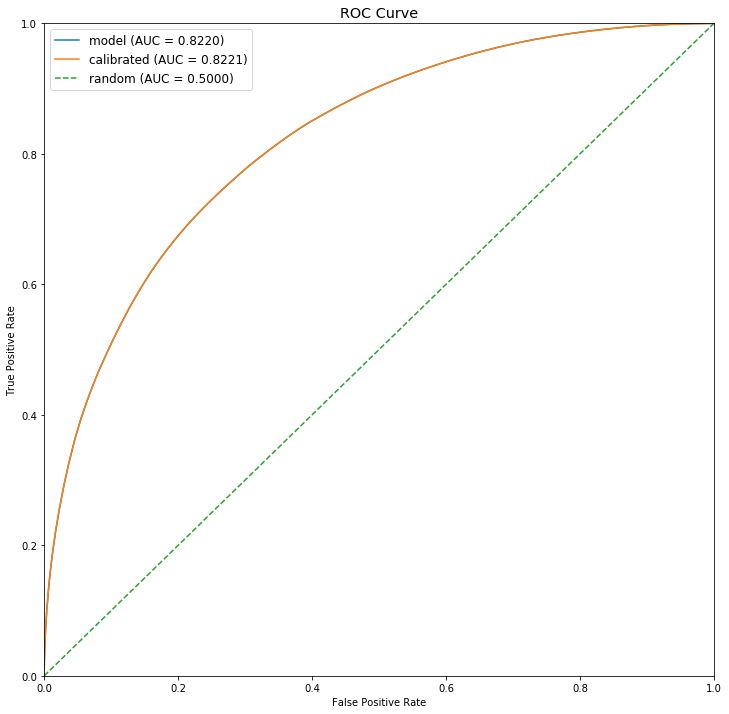

In [49]:
fig = plt.figure(figsize=(12, 12))
plt.plot(curve_df.fpr, curve_df.tpr, marker='', label='model (AUC = {0:.4f})'.format(area_under_roc))
plt.plot(curve_df.fpr_c, curve_df.tpr_c, marker='', label='calibrated (AUC = {0:.4f})'.format(area_under_roc_cal))
plt.plot([0, 1], [0, 1], marker='', linestyle='--', label='random (AUC = 0.5000)')
plt.legend(loc='best', fontsize='large')
plt.title('ROC Curve', fontsize='x-large')
plt.xlabel('False Positive Rate')
plt.xlim(0, 1)
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
fig

### Recency Aggregations

Isotonic calibration reduces log loss for the near term (<60 days until deact) by raising deact probabilities.

In [24]:
recency = pred_df_iso \
    .filter((F.col('recency_x') >= 0) & (F.col('recency_x') <= 365)) \
    .withColumn('days_until_deact', (F.lit(365) - F.col('recency_x')).cast(IntegerType())) \
    .withColumn('log_loss', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact')))) \
    .withColumn('log_loss_cal', F.when(F.col('deactivated') == 1, -F.log(F.col('prob_deact_cal')))
        .otherwise(-F.log(F.lit(1.0) - F.col('prob_deact_cal')))) \
    .withColumn('prediction_cal', F.round(F.col('prob_deact_cal'), 0)) \
    .groupBy('days_until_deact') \
    .agg(F.count('consumer_id').alias('count_users'),
        F.sum('deactivated').alias('deacts_actual'),
        F.sum('prob_deact').cast(IntegerType()).alias('deacts_pred'),
        F.sum('prob_deact_cal').cast(IntegerType()).alias('deacts_pred_cal'),
        F.avg('log_loss').alias('avg_log_loss'),
        F.avg('log_loss_cal').alias('avg_log_loss_cal'),
        F.avg('prob_deact').alias('avg_prob_deact'),
        F.avg('prob_deact_cal').alias('avg_prob_deact_cal'),
        # Accuracy uses "prediction" column, which assigns consumers to class based on cutoff point of 0.50
        F.avg((F.col('deactivated') == F.col('prediction')).cast(IntegerType())).alias('accuracy'),
        F.avg((F.col('deactivated') == F.col('prediction_cal')).cast(IntegerType())).alias('accuracy_cal'),
        ) \
    .withColumn('pct_deact_actual', F.col('deacts_actual') / F.col('count_users')) \
    .withColumn('pct_deact_pred', F.col('deacts_pred') / F.col('count_users')) \
    .withColumn('pct_deact_pred_cal', F.col('deacts_pred_cal') / F.col('count_users')) \
    .withColumn('diff_pct_deact', F.col('pct_deact_pred') - F.col('pct_deact_actual')) \
    .withColumn('diff_pct_deact_cal', F.col('pct_deact_pred_cal') - F.col('pct_deact_actual')) \
    .sort('days_until_deact') \
    .toPandas()

recency.head(10)

,days_until_deact,count_users,deacts_actual,deacts_pred,deacts_pred_cal,avg_log_loss,avg_log_loss_cal,avg_prob_deact,avg_prob_deact_cal,accuracy,accuracy_cal,pct_deact_actual,pct_deact_pred,pct_deact_pred_cal,diff_pct_deact,diff_pct_deact_cal
0,0,6276,6276,5905,6149,0.060904,0.020485,0.941005,0.979922,1.000000,1.000000,1.000000,0.940886,0.979764,-0.059114,-0.020236
1,1,6349,6340,5980,6231,0.063367,0.023331,0.942036,0.981486,0.998582,0.998582,0.998582,0.941881,0.981414,-0.056702,-0.017168
2,2,5529,5499,5208,5426,0.073722,0.037103,0.941965,0.981424,0.994574,0.994574,0.994574,0.941942,0.981371,-0.052632,-0.013203
3,3,5693,5659,5358,5578,0.076236,0.041074,0.941164,0.979892,0.994028,0.994028,0.994028,0.941156,0.979800,-0.052872,-0.014228
4,4,5492,5433,5167,5379,0.088264,0.056615,0.940908,0.979550,0.989257,0.989257,0.989257,0.940823,0.979425,-0.048434,-0.009832
5,5,4927,4882,4633,4823,0.085558,0.054510,0.940479,0.978995,0.990867,0.990867,0.990867,0.940329,0.978892,-0.050538,-0.011975
6,6,4638,4582,4362,4540,0.092916,0.063060,0.940504,0.979032,0.987926,0.987926,0.987926,0.940492,0.978870,-0.047434,-0.009056
7,7,5010,4920,4712,4905,0.107956,0.084373,0.940595,0.979113,0.982036,0.982036,0.982036,0.940519,0.979042,-0.041517,-0.002994
8,8,5719,5629,5379,5600,0.102982,0.078429,0.940645,0.979246,0.984263,0.984263,0.984263,0.940549,0.979192,-0.043714,-0.005071
9,9,5346,5234,5022,5226,0.115851,0.092648,0.939543,0.977569,0.979050,0.979050,0.979050,0.939394,0.977553,-0.039656,-0.001496


In [25]:
plots = [
    {'y': 'count_users', 'title': 'Number of Consumers', 'label': None, 'baseline': False, 'y2': False},
    {'y': 'avg_log_loss', 'title': 'Average Log Loss', 'label': 'Model',
        'baseline': {'y': [0.] * len(recency), 'label': 'Ideal', 'linestyle': '--'},
        'y2': 'avg_log_loss_cal'},
    {'y': 'avg_prob_deact', 'title': 'Average Probability of Deactivation', 'label': 'Model',
        'baseline': {'y': recency.pct_deact_actual, 'label': 'Actual', 'linestyle': '-'},
        'y2': 'avg_prob_deact_cal'},
    {'y': 'diff_pct_deact', 'title': '(% Predicted - % Actual) Deactivations', 'label': 'Model',
        'baseline': {'y': [0.] * len(recency), 'label': 'Ideal', 'linestyle': '--'},
        'y2': 'diff_pct_deact_cal'},
    {'y': 'accuracy', 'title': 'Accuracy', 'label': 'Model',
        'baseline': {'y': [1.] * len(recency), 'label': 'Ideal', 'linestyle': '--'},
        'y2': 'accuracy_cal'},
]

d = {}
for i, p in enumerate(plots):
    fig = plt.figure(figsize=(12, 12))
    plt.plot(recency.days_until_deact, recency[p['y']], marker='', label=p['label'])
    if p['y2']:
        plt.plot(recency.days_until_deact, recency[p['y2']], marker='', label='Calibrated')
    if p['baseline']:
        plt.plot(recency.days_until_deact, p['baseline']['y'], marker='',
            linestyle=p['baseline']['linestyle'], label=p['baseline']['label'])
        plt.legend(loc='best', fontsize='large')
    plt.title(p['title'], fontsize='x-large')
    plt.xlabel('Days Until Deactivation (365 - Recency)')
    plt.xlim(0, 365)
    d['fig'+str(i)] = fig

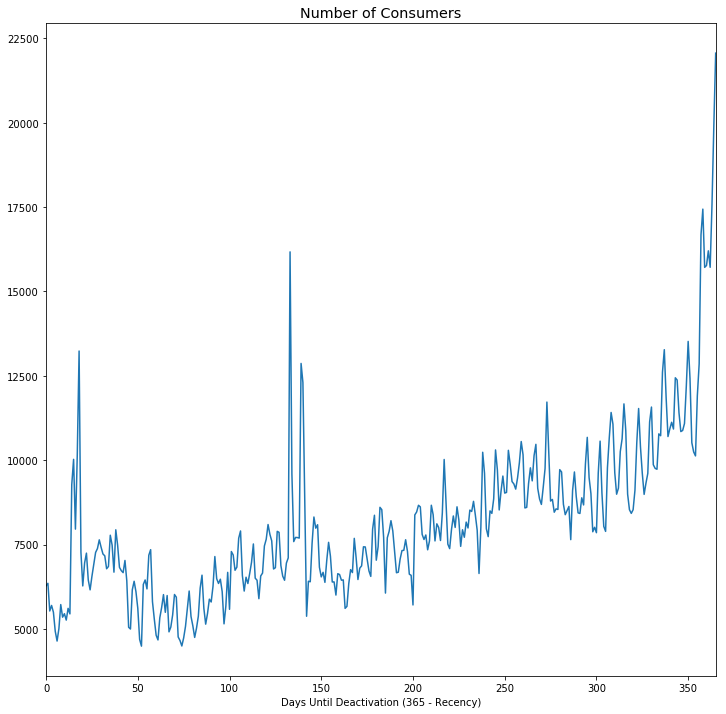

In [26]:
d['fig0']

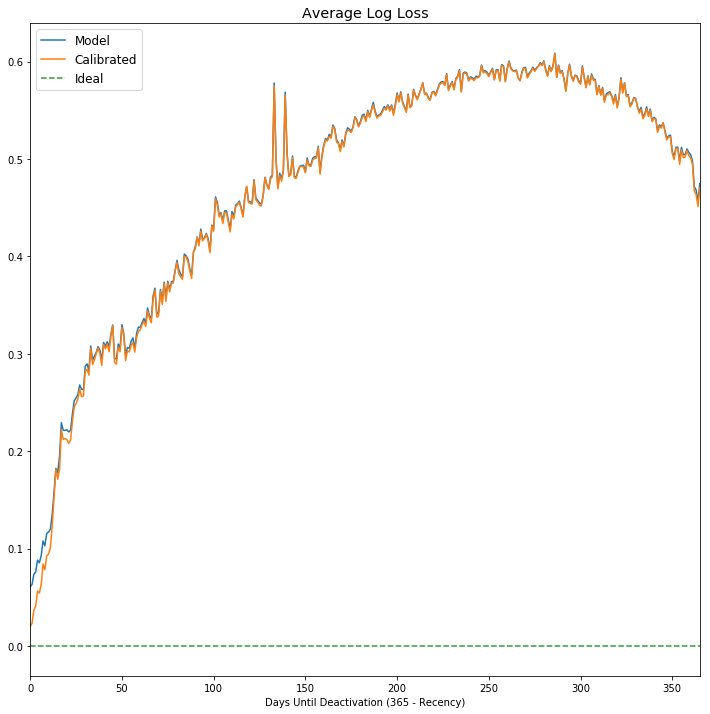

In [27]:
d['fig1']

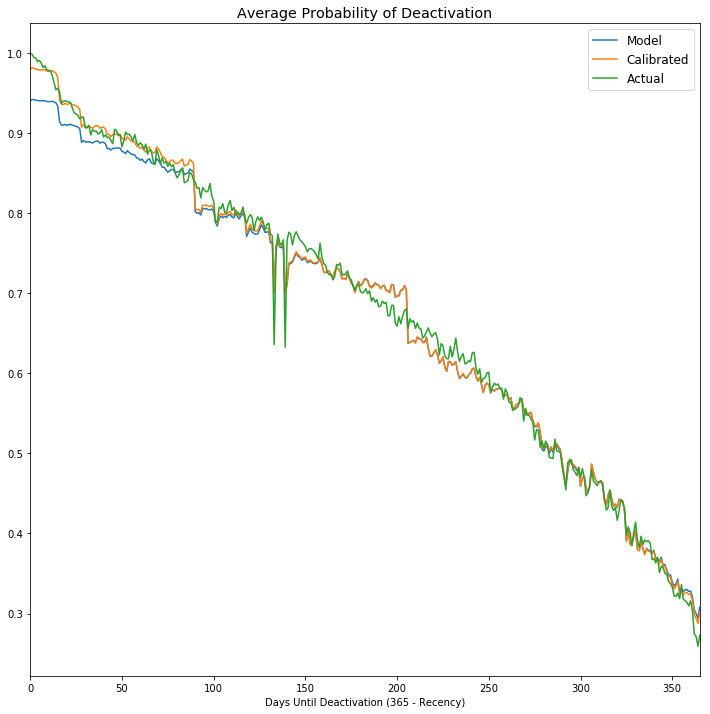

In [28]:
d['fig2']

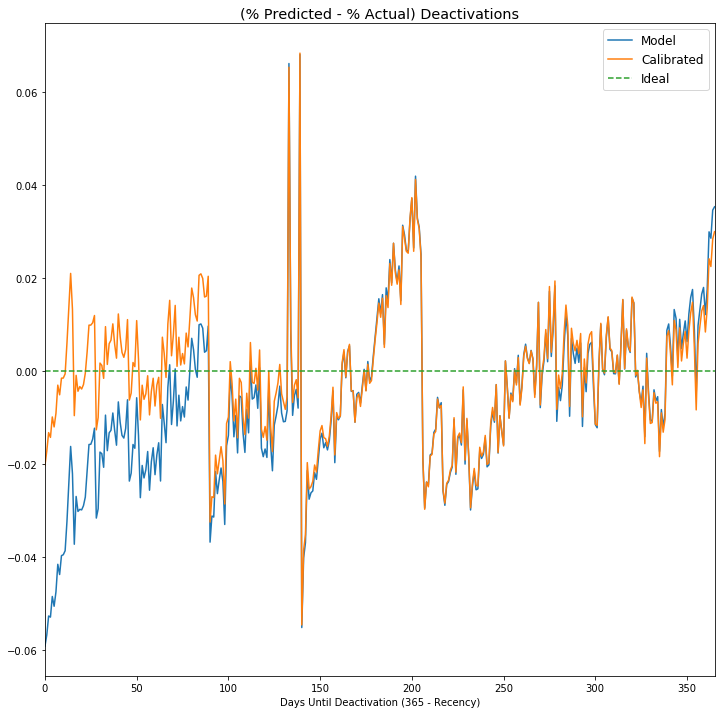

In [29]:
d['fig3']

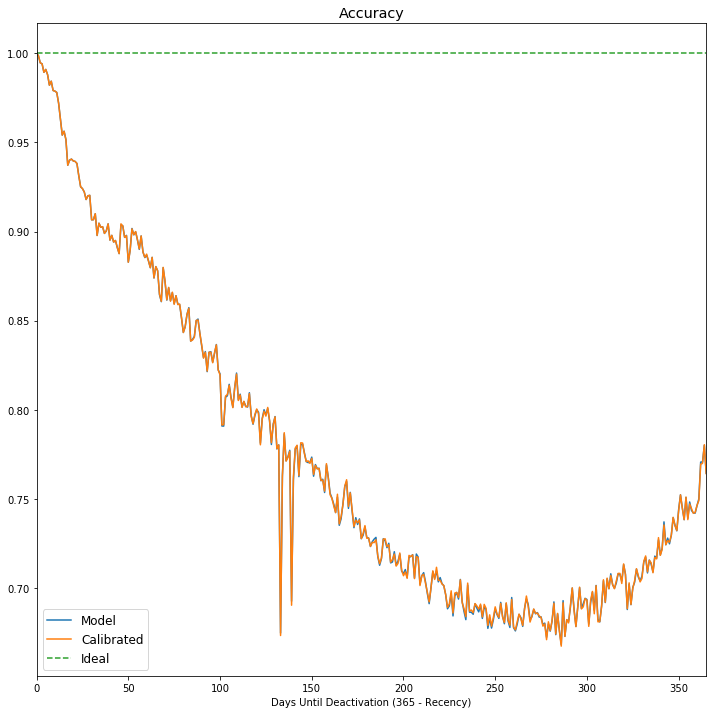

In [30]:
d['fig4']